<a href="https://colab.research.google.com/github/punyamsingh/IRIS/blob/main/Evaluation-Precision-recall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upgrade torch and sentence-transformers to compatible versions
!pip install --upgrade torch sentence-transformers


STEP BY STEP NEW APPROACH.
LATEST
1. Calculate cosine similarity between query and tag vectors of all images
2. Define a certain threshold to classify images as relevant and non relevant for a particular query
3. Run the model and retrieve ranked set of images
4. Compute metric scores

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import json
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

# Download NLTK resources for lemmatization and stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Load data
csv_file = '/content/multilabel_classification(2).csv'  # replace with actual path
json_file = '/content/image_tags.json'  # replace with actual path

# Step 1: Load and Filter CSV Data
csv_data = pd.read_csv(csv_file)
with open(json_file, 'r') as f:
    image_tags_mapping = json.load(f)

# Filter CSV to only include images present in JSON data
csv_data = csv_data[csv_data['Image_Name'].isin(image_tags_mapping.keys())].reset_index(drop=True)

# Columns representing tag presence (binary vector fields)
original_tag_columns = csv_data.columns[2:]  # Assuming first two columns are 'Image_Name' and 'Classes'

# Step 2: Lemmatize CSV Columns for Consistency and Remove Stopwords
tag_columns = [lemmatizer.lemmatize(tag) for tag in original_tag_columns if tag not in stop_words]
csv_data.columns = list(csv_data.columns[:2]) + tag_columns  # Replace with processed columns

# Step 3: Formulate Query with Lemmatization and Stopword Removal
query_terms = ["boat"]  # Example terms, feel free to adjust
lemmatized_query_terms = [lemmatizer.lemmatize(term) for term in query_terms if term not in stop_words]

# Create binary vector for query
query_vector = np.array([1 if col in lemmatized_query_terms else 0 for col in tag_columns]).reshape(1, -1)

# Step 4: Compute Cosine Similarity between Query Vector and each Image Vector
image_vectors = csv_data[tag_columns].values  # Extract binary vectors for each image
similarities = cosine_similarity(query_vector, image_vectors).flatten()  # Cosine similarity with query

# Step 5: Set Threshold and Classify as Relevant or Non-Relevant
threshold = 0.3  # Define your threshold for relevance

# Create lists for relevant and non-relevant images
relevant_images = [(img, score) for img, score in zip(csv_data['Image_Name'], similarities) if score >= threshold]
non_relevant_images = [(img, score) for img, score in zip(csv_data['Image_Name'], similarities) if score < threshold]
print(len(relevant_images))
# print(len(non_relevant_images
# Print relevant images
print("Relevant Images based on Similarity (Threshold = 0.5):")

for image, score in relevant_images:
    print(f"Image: {image}, Similarity Score: {score}")

# Print non-relevant images
print("\nNon-Relevant Images based on Similarity (Below Threshold):")
for image, score in non_relevant_images:
    print(f"Image: {image}, Similarity Score: {score}")


45
Relevant Images based on Similarity (Threshold = 0.5):
Image: image4625.jpg, Similarity Score: 0.7071067811865475
Image: image4626.jpg, Similarity Score: 0.5
Image: image4627.jpg, Similarity Score: 0.5773502691896258
Image: image4628.jpg, Similarity Score: 0.5773502691896258
Image: image4629.jpg, Similarity Score: 0.5
Image: image4630.jpg, Similarity Score: 1.0
Image: image4631.jpg, Similarity Score: 0.5
Image: image4632.jpg, Similarity Score: 0.4472135954999579
Image: image4633.jpg, Similarity Score: 0.5
Image: image4634.jpg, Similarity Score: 0.5773502691896258
Image: image4635.jpg, Similarity Score: 0.5773502691896258
Image: image4636.jpg, Similarity Score: 0.4472135954999579
Image: image4637.jpg, Similarity Score: 0.7071067811865475
Image: image4638.jpg, Similarity Score: 0.5773502691896258
Image: image4639.jpg, Similarity Score: 0.5773502691896258
Image: image4640.jpg, Similarity Score: 0.5
Image: image4641.jpg, Similarity Score: 0.5
Image: image4642.jpg, Similarity Score: 0.70

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
import os
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
from PIL import Image
from IPython.display import display

# Load the image tags from the JSON file
with open('image_tags.json', 'r') as f:
    image_tags_mapping = json.load(f)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Initialize the Sentence Transformer model for semantic similarity
st_model = SentenceTransformer('all-mpnet-base-v2')

# Predefined relevance lists from human tagging (from the first code's results)
# Replace these lists with the results from the first code
human_relevant_images = relevant_images.copy()  # Example list of relevant image names
human_non_relevant_images = non_relevant_images.copy()  # Example list of non-relevant image names

print(human_relevant_images)

def get_literal_similarity(query, image_tags):
    """Calculate literal similarity between the query and image tags using TF-IDF."""
    all_tags = ' '.join(image_tags)
    X = tfidf_vectorizer.fit_transform([query, all_tags])
    literal_sim = 1 - cosine(X[0].toarray().flatten(), X[1].toarray().flatten())
    return literal_sim

def get_semantic_similarity(query, image_tags):
    """Calculate semantic similarity between the query and image tags using Sentence Transformer."""
    query_embed = st_model.encode(query)
    tags_embed = st_model.encode(image_tags)
    tags_mean_embed = np.mean(tags_embed, axis=0)
    semantic_sim = 1 - cosine(query_embed, tags_mean_embed)
    return semantic_sim

def rank_images(query):
    """Rank images based on the sum of literal and semantic similarity scores to the query."""
    similarity_scores = []
    for filename, tags in image_tags_mapping.items():
        literal_sim = get_literal_similarity(query, tags)
        semantic_sim = get_semantic_similarity(query, tags)
        total_score = literal_sim + semantic_sim
        similarity_scores.append((filename, literal_sim, semantic_sim, total_score))

    # Sort images based on the combined score
    similarity_scores.sort(key=lambda x: x[3], reverse=True)

    return similarity_scores
def calculate_precision_recall_step_by_step(similarity_scores):
    """Calculate precision and recall at each retrieval step."""
    # Extract only the image names from human_relevant_images
    relevant_image_names = {img[0] for img in human_relevant_images}
    relevant_count = 0  # Count of relevant images encountered so far
    total_relevant_images = len(relevant_image_names)  # Total number of human-tagged relevant images

    print("Step-by-step Precision and Recall:")
    for i, (image, _, _, _) in enumerate(similarity_scores):
        # Check if the current image is relevant according to human tagging
        is_relevant = image in relevant_image_names
        if is_relevant:
            relevant_count += 1  # Increment relevant count if current image is relevant

        # Calculate precision and recall at this step
        precision = relevant_count / (i + 1)
        recall = relevant_count / total_relevant_images

        # Debugging output to verify relevancy checks
        print(f"Image {i + 1}: {image} - Relevant: {is_relevant}")
        print(f"Precision = {precision:.4f}, Recall = {recall:.4f}")

# Example usage
query = "Boat"
similarity_scores = rank_images(query)  # Get ranked images based on your query

# Calculate and display precision and recall step by step
calculate_precision_recall_step_by_step(similarity_scores)

# Extract relevant and non-relevant images based on human tagging
model_relevant_images = [(img, score) for img, _, _, score in similarity_scores if img in human_relevant_images]
model_non_relevant_images = [(img, score) for img, _, _, score in similarity_scores if img in human_non_relevant_images]

# Display the ranked images (just names) from earlier corpus and model
print("\nRanked Images (From Model):")
for image, _, _, _ in similarity_scores:
    print(image)


[('image4625.jpg', 0.7071067811865475), ('image4626.jpg', 0.5), ('image4627.jpg', 0.5773502691896258), ('image4628.jpg', 0.5773502691896258), ('image4629.jpg', 0.5), ('image4630.jpg', 1.0), ('image4631.jpg', 0.5), ('image4632.jpg', 0.4472135954999579), ('image4633.jpg', 0.5), ('image4634.jpg', 0.5773502691896258), ('image4635.jpg', 0.5773502691896258), ('image4636.jpg', 0.4472135954999579), ('image4637.jpg', 0.7071067811865475), ('image4638.jpg', 0.5773502691896258), ('image4639.jpg', 0.5773502691896258), ('image4640.jpg', 0.5), ('image4641.jpg', 0.5), ('image4642.jpg', 0.7071067811865475), ('image4643.jpg', 0.7071067811865475), ('image4644.jpg', 0.7071067811865475), ('image4645.jpg', 0.5773502691896258), ('image4646.jpg', 0.5773502691896258), ('image4647.jpg', 0.5773502691896258), ('image4648.jpg', 0.5773502691896258), ('image4649.jpg', 0.5773502691896258), ('image4650.jpg', 0.5), ('image4651.jpg', 0.5773502691896258), ('image4652.jpg', 0.5773502691896258), ('image4653.jpg', 0.5773502

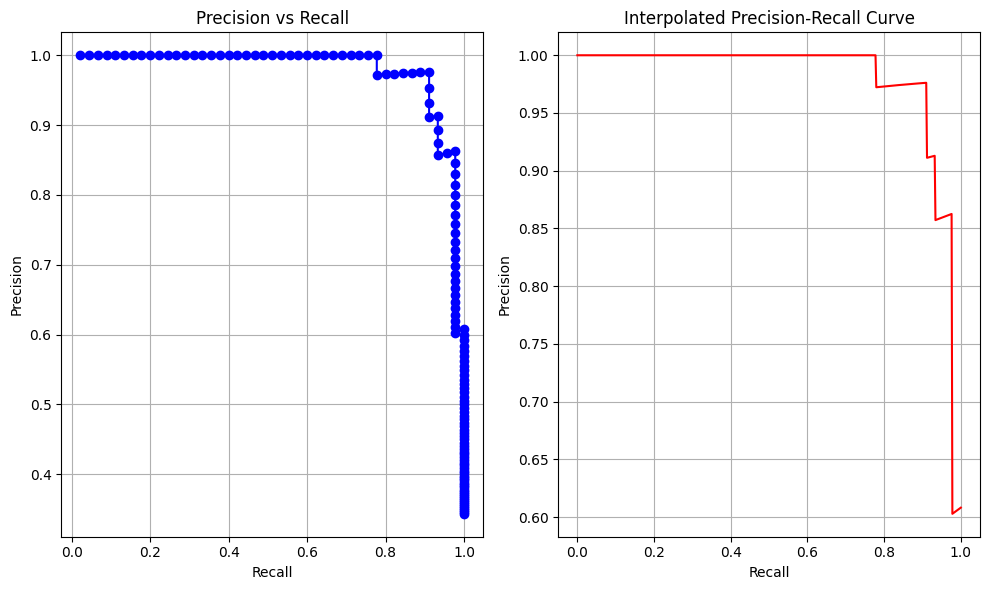

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Assuming you have the precision and recall values from the previous code
# Store them in lists for plotting
precision_values = []
recall_values = []

# Example: Assuming 'similarity_scores' has been calculated and contains precision/recall
def calculate_precision_recall_step_by_step(similarity_scores):
    """Calculate precision and recall at each retrieval step."""
    # Extract only the image names from human_relevant_images
    relevant_image_names = {img[0] for img in human_relevant_images}
    relevant_count = 0  # Count of relevant images encountered so far
    total_relevant_images = len(relevant_image_names)  # Total number of human-tagged relevant images

    for i, (image, _, _, _) in enumerate(similarity_scores):
        # Check if the current image is relevant according to human tagging
        is_relevant = image in relevant_image_names
        if is_relevant:
            relevant_count += 1  # Increment relevant count if current image is relevant

        # Calculate precision and recall at this step
        precision = relevant_count / (i + 1)
        recall = relevant_count / total_relevant_images

        # Append values for plotting
        precision_values.append(precision)
        recall_values.append(recall)

# Example usage
query = "Boat"
similarity_scores = rank_images(query)  # Get ranked images based on your query

# Calculate and store precision and recall
calculate_precision_recall_step_by_step(similarity_scores)

# Plot Precision vs Recall curve
plt.figure(figsize=(10, 6))

# Plot Precision-Recall curve
plt.subplot(1, 2, 1)
plt.plot(recall_values, precision_values, marker='o', linestyle='-', color='b')
plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

# Interpolate for a smooth Precision-Recall curve
from scipy.interpolate import interp1d
interp_recall = np.linspace(0, 1, num=500)  # Interpolate over a finer range of recall
interp_precision = interp1d(recall_values, precision_values, kind='linear', fill_value="extrapolate")(interp_recall)

# Plot interpolated Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(interp_recall, interp_precision, linestyle='-', color='r')
plt.title('Interpolated Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


JACCARD

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_score
import json
from nltk.stem import WordNetLemmatizer
import nltk

# Download NLTK resources for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Load data
csv_file = '/content/multilabel_classification(2).csv'  # replace with actual path
json_file = '/content/image_tags.json'  # replace with actual path

# Step 1: Load and Filter CSV Data
csv_data = pd.read_csv(csv_file)
with open(json_file, 'r') as f:
    image_tags_mapping = json.load(f)

# Filter CSV to only include images present in JSON data
csv_data = csv_data[csv_data['Image_Name'].isin(image_tags_mapping.keys())].reset_index(drop=True)

# Step 2: Lemmatize CSV Columns for Consistency
# Columns representing tag presence (binary vector fields)
original_tag_columns = csv_data.columns[2:]  # Assuming first two columns are 'Image_Name' and 'Classes'

# Lemmatize each column name
tag_columns = [lemmatizer.lemmatize(tag) for tag in original_tag_columns]
csv_data.columns = list(csv_data.columns[:2]) + tag_columns

# Step 3: Formulate Query with Lemmatization
query_terms = ["sitars"]  # Example terms; feel free to adjust

# Lemmatize query terms
lemmatized_query_terms = [lemmatizer.lemmatize(term) for term in query_terms]

# Create binary vector for query
query_vector = np.array([1 if col in lemmatized_query_terms else 0 for col in tag_columns]).reshape(1, -1)

# Step 4: Compute Jaccard Similarity between Query Vector and each Image Vector
image_vectors = csv_data[tag_columns].values  # Extract binary vectors for each image
jaccard_similarities = [jaccard_score(query_vector.flatten(), img_vec, average='binary') for img_vec in image_vectors]

# Step 5: Rank Images Based on Jaccard Similarity Scores
ranked_images = sorted(
    zip(csv_data['Image_Name'], jaccard_similarities),
    key=lambda x: x[1],
    reverse=True
)

# Print top-ranked images
print("Ranked Images based on Jaccard Similarity (Highest to Lowest):")
for image, score in ranked_images:
    print(f"Image: {image}, Similarity Score: {score}")


In [8]:
import pandas as pd
import json

# Load the CSV and JSON files
csv_file = '/content/multilabel_classification(2).csv'  # Replace with the actual path
json_file = '/content/image_tags.json'  # Replace with the actual path

# Load CSV data
csv_data = pd.read_csv(csv_file)

# Load image names from JSON
with open(json_file, 'r') as f:
    image_tags_mapping = json.load(f)
image_names = set(image_tags_mapping.keys())

# Filter CSV to include only images present in JSON data
filtered_csv_data = csv_data[csv_data['Image_Name'].isin(image_names)].reset_index(drop=True)

# Save the filtered data to a new CSV file
filtered_csv_file = '/content/filtered_images.csv'  # Replace with desired path
filtered_csv_data.to_csv(filtered_csv_file, index=False)

print(f"Filtered data has been saved to {filtered_csv_file}")


Filtered data has been saved to /content/filtered_images.csv
